**SMS SPAM Classification**

**1.Download The Dataset :** [Dataset](https://www.kaggle.com/code/kredy10/simple-lstm-for-text-classification/data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.Import required library**

In [2]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [4]:
import nltk
nltk.download('stopwords')  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**3.Read dataset and do pre-processing**

In [5]:
data=pd.read_csv("/content/drive/MyDrive/spam.csv",encoding="latin")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [7]:
data=data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [9]:
data=data.rename({"v1":"Category","v2":"Message"},axis=1)
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [10]:
data["Message Length"]=data["Message"].apply(len)

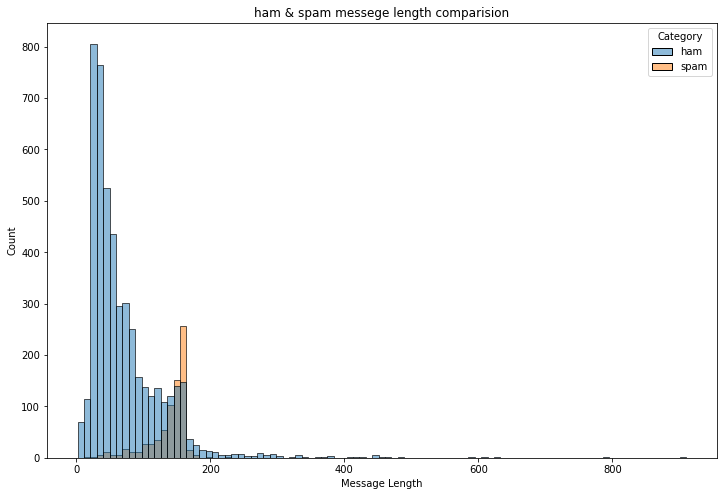

In [11]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [12]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [13]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

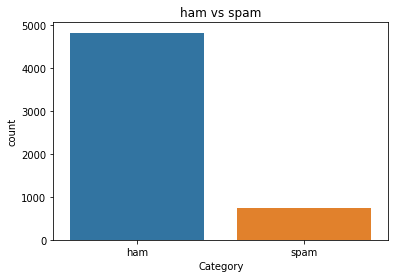

In [14]:
sns.countplot(data=data,x="Category")
plt.title("ham vs spam")
plt.show()

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [17]:
#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)

In [18]:
df.shape

(1494, 3)

In [19]:
df["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [20]:
df["Label"]=df["Category"].map({"ham":0,"spam":1})

In [21]:
stemmer=PorterStemmer()

In [22]:
#declare empty list to store tokenized message
corpus=[]

#iterate through the df["Message"]
for message in df["Message"]:
    
    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)
    
    #convert every letters to its lowercase
    message=message.lower()
    
    #split the word into individual word list
    message=message.split()
    
    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    #join the word lists with the whitespace
    message=" ".join(message)
    
    #append the message in corpus list
    corpus.append(message)

In [23]:
vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [24]:
df["Message Length"].describe()

count    1494.000000
mean      104.854083
std        54.568061
min         2.000000
25%        49.000000
50%       121.000000
75%       153.000000
max       384.000000
Name: Message Length, dtype: float64

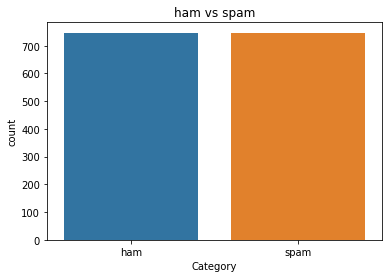

In [25]:
sns.countplot(data=df,x="Category")
plt.title("ham vs spam")
plt.show()

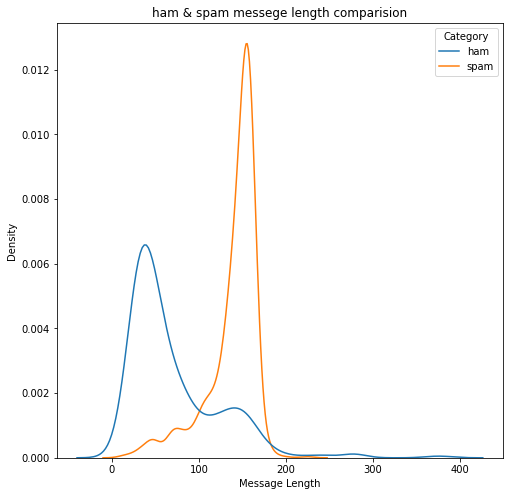

In [27]:
fig=plt.figure(figsize=(8,8))
sns.kdeplot(x=df["Message Length"],hue=df["Category"])
plt.title("ham & spam messege length comparision")
plt.show()

**4.Create Model**

In [29]:
sentence_len=200
embedded_doc=pad_sequences(oneHot_doc,maxlen=sentence_len,padding="pre")
extract_features=pd.DataFrame(data=embedded_doc)
target=df["Label"]

In [30]:
df_final=pd.concat([extract_features,target],axis=1)
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,5450,4116,2084,2812,4142,3508,3923,1083,3977,0
1,0,0,0,0,0,0,0,0,0,0,...,9690,5007,7762,2201,1591,7220,8834,8928,9982,1
2,0,0,0,0,0,0,0,0,0,0,...,9690,5597,8440,2828,2407,501,5007,7876,49,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8591,9792,9019,8030,0
4,0,0,0,0,0,0,0,0,0,0,...,723,7860,3229,8287,1594,2017,7094,3874,3180,1


In [31]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]
X_trainval,X_test,y_trainval,y_test=train_test_split(X,y,random_state=42,test_size=0.15)
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval,random_state=42,test_size=0.15)

In [32]:
model=Sequential()

**5.Add Layers (LSTM, Dense-(Hidden Layers), Output)**

In [33]:
feature_num=100
model.add(Embedding(input_dim=vocab_size,output_dim=feature_num,input_length=sentence_len))
model.add(LSTM(units=128))
model.add(Dense(units=1,activation="sigmoid"))

**6.Compile the Model**

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

**7.Fit the Model**

In [35]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
34/34 [==============================] - 17s 381ms/step - loss: 0.5160 - accuracy: 0.7301 - val_loss: 0.3182 - val_accuracy: 0.8848
Epoch 2/10
34/34 [==============================] - 12s 343ms/step - loss: 0.1638 - accuracy: 0.9462 - val_loss: 0.1194 - val_accuracy: 0.9686
Epoch 3/10
34/34 [==============================] - 14s 416ms/step - loss: 0.0582 - accuracy: 0.9814 - val_loss: 0.0819 - val_accuracy: 0.9791
Epoch 4/10
34/34 [==============================] - 12s 344ms/step - loss: 0.0298 - accuracy: 0.9889 - val_loss: 0.0839 - val_accuracy: 0.9738
Epoch 5/10
34/34 [==============================] - 14s 414ms/step - loss: 0.0201 - accuracy: 0.9963 - val_loss: 0.0990 - val_accuracy: 0.9529
Epoch 6/10
34/34 [==============================] - 14s 429ms/step - loss: 0.0121 - accuracy: 0.9944 - val_loss: 0.1043 - val_accuracy: 0.9686
Epoch 7/10
34/34 [==============================] - 12s 344ms/step - loss: 0.0581 - accuracy: 0.9889 - val_loss: 0.1537 - val_accuracy: 0.9476

**8.Save The Model**

In [36]:
model.save('sms_classifier.h5')

**9.Test The Model**

In [37]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

8/8 [==============================] - 1s 96ms/step


In [38]:
score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:96.00%


In [39]:
#The function take model and message as parameter
def classify_message(model,message):
    
    #We will treat message as a paragraphs containing multiple sentences(lines)
    #we will extract individual lines
    for sentences in message:
        sentences=nltk.sent_tokenize(message)
        
        #Iterate over individual sentences
        for sentence in sentences:
            #replace all special characters
            words=re.sub("[^a-zA-Z]"," ",sentence)
            
            #perform word tokenization of all non-english-stopwords
            if words not in set(stopwords.words('english')):
                word=nltk.word_tokenize(words)
                word=" ".join(word)
    
    #perform one_hot on tokenized word            
    oneHot=[one_hot(word,n=vocab_size)]
    
    #create an embedded documnet using pad_sequences 
    #this can be fed to our model
    text=pad_sequences(oneHot,maxlen=sentence_len,padding="pre")
    
    #predict the text using model
    predict=model.predict(text)
    
    #if predict value is greater than 0.5 its a spam
    if predict>0.5:
        print("It is a spam")
    #else the message is not a spam    
    else:
        print("It is not a spam")

In [40]:
message1="I am having a bad day and I would like to have a break today"
message2="This is to inform you had won a lottery and the subscription will end in a week so call us."

In [41]:
classify_message(model,message1)

1/1 [==============================] - 0s 105ms/step
It is not a spam


In [42]:
classify_message(model,message2)

1/1 [==============================] - 0s 33ms/step
It is not a spam
